[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/pinecone-io/examples/blob/master/learn/search/faiss-ebook/locality-sensitive-hashing-random-projection/faiss_implementation.ipynb) [![Open nbviewer](https://raw.githubusercontent.com/pinecone-io/examples/master/assets/nbviewer-shield.svg)](https://nbviewer.org/github/pinecone-io/examples/blob/master/learn/search/faiss-ebook/locality-sensitive-hashing-random-projection/faiss_implementation.ipynb)

In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

# now define a function to read the fvecs file format of Sift1M dataset
def read_fvecs(fp):
    a = np.fromfile(fp, dtype='int32')
    d = a[0]
    return a.reshape(-1, d + 1)[:, 1:].copy().view('float32')

# 1M samples
wb = read_fvecs('../../../../data/sift/sift_base.fvecs')
# queries
xq = read_fvecs('../../../../data/sift/sift_query.fvecs')

In [2]:
wb.shape

(1000000, 128)

In [3]:
import faiss

d = wb.shape[1]
nbits = 4

# initialize the index using our vectors dimensionality (128) and nbits
index = faiss.IndexLSH(d, nbits)
# then add the data
index.add(wb)

In [4]:
xq0 = xq[0].reshape(1, d)
# we use the search method to find the k nearest vectors
D, I = index.search(xq0, k=10)
# the indexes of these vectors are returned to I
I

array([[26, 47, 43,  2,  6, 70, 73, 74, 25,  0]])

In [5]:
# we can retrieve the original vectors from wb using these indexes
wb[I[0]]

array([[31., 15., 47., ...,  0.,  1., 19.],
       [ 0.,  0.,  0., ...,  0., 30., 72.],
       [22., 15., 43., ...,  0.,  0., 12.],
       ...,
       [ 6., 15.,  9., ..., 12., 17., 21.],
       [33., 22.,  8., ...,  0., 11., 69.],
       [ 0., 16., 35., ..., 25., 23.,  1.]], dtype=float32)

In [6]:
# and calculate the cosine similarity between each of these vectors and xq[0]
cosine_similarity(wb[I[0]], [xq[0]])

array([[0.7344476 ],
       [0.6316513 ],
       [0.6995599 ],
       [0.20448919],
       [0.3054034 ],
       [0.25432232],
       [0.30497947],
       [0.341374  ],
       [0.6914262 ],
       [0.26704744]], dtype=float32)

Why is the index performing so poorly? Well, we already know why. All of these vectors are stored in the LSH index under the same 4-digit, low resolution hash. We can confirm this by checking the other variable returned from our search, `D` - the *distances* calculated by our LSH index.

In [7]:
D

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

A perfect *zero* for every single item. We know that the *Hamming distance* can only be **0** for perfect matches. So, there is only one hash bucket that will score **0**. This means that we can check how many of our vectors have been stored within this single LSH bucket by finding the point that the Hamming distance reaches 1? Let's search again, this time increasing `k` until we return a `D` array that contains more than just *zeros*.

In [8]:
k = 100
xq0 = xq[0].reshape(1, d)

while True:
    D, I = index.search(xq0, k=k)
    if D.any() != 0:
        print(k)
        break
    k += 100

172100


In [9]:
D  # we will see both 0s, and 1s

array([[0., 0., 0., ..., 1., 1., 1.]], dtype=float32)

In [10]:
D[:, 172_039:172_041]  # we see the hash code switch at position 172_039

array([[0., 1.]], dtype=float32)

What `nbits` value gives us a better chance for a more sparse distribution of our vectors?

In [11]:
for nbits in [2, 4, 8, 16, 24, 32]:
    buckets = 1 << nbits
    print(f"nbits == {nbits}")
    print(f"{wb.shape[0]} / {buckets} = {wb.shape[0]/buckets}")

nbits == 2
1000000 / 4 = 250000.0
nbits == 4
1000000 / 16 = 62500.0
nbits == 8
1000000 / 256 = 3906.25
nbits == 16
1000000 / 65536 = 15.2587890625
nbits == 24
1000000 / 16777216 = 0.059604644775390625
nbits == 32
1000000 / 4294967296 = 0.00023283064365386963


In [12]:
xq0 = xq[0].reshape(1, d)
k = 100

for nbits in [2, 4, 8, 16, 24, 32]:
    index = faiss.IndexLSH(d, nbits)
    index.add(wb)
    D, I = index.search(xq0, k=k)
    cos = cosine_similarity(wb[I[0]], xq0)
    print(np.mean(cos))

0.5424448
0.560827
0.6372647
0.6676912
0.7162514
0.7048228


In [13]:
xq0 = xq[0].reshape(1, d)
k = 100

results = pd.DataFrame({
    'nbits': [],
    'cosine_sim': []
})

for epoch in range(20):
    print('.', end='')
    for nbits in [2, 4, 8, 16, 24, 32, 64, 128]:
        index = faiss.IndexLSH(d, nbits)
        index.add(wb)
        D, I = index.search(xq0, k=k)
        cos = cosine_similarity(wb[I[0]], xq0)
        df = pd.DataFrame({
            'cosine_sim': cos.reshape(cos.shape[0])
        })
        df['nbits'] = nbits
        results = results.append(df, ignore_index=True)

....................

<AxesSubplot:xlabel='nbits', ylabel='cosine_sim'>

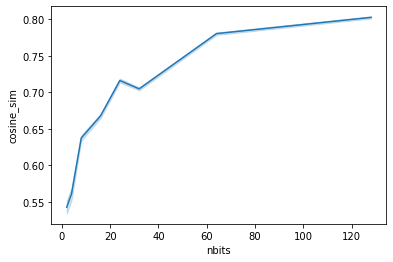

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.lineplot(data=results, x='nbits', y='cosine_sim')

## Assessing Issues

We can also extract the vectors from our index, first let's initialize a new index with `nbits == 4`

In [15]:
nbits = 4
index = faiss.IndexLSH(d, nbits)
index.add(wb)

And extract the actual binary vectors stored inside our LSH index like so.

In [16]:
# extract index binary codes (represented as int)
arr = faiss.vector_to_array(index.codes)
arr

array([ 5, 12,  5, ..., 15, 13, 12], dtype=uint8)

In [17]:
# we see that there are 1M of these values, 1 for each vector
arr.shape

(1000000,)

We can convert these into our binary vector format like so:

In [18]:
bin_vecs = (((arr[:, None] & (1 << np.arange(nbits)))) > 0).astype(int)
bin_vecs

array([[1, 0, 1, 0],
       [0, 0, 1, 1],
       [1, 0, 1, 0],
       ...,
       [1, 1, 1, 1],
       [1, 0, 1, 1],
       [0, 0, 1, 1]])

And convert them into strings for bucketing too:

In [19]:
dist_arr = np.apply_along_axis(lambda x: ''.join(x), 1, bin_vecs.astype(str))

In [20]:
order_bins = ['0'* (6-len(bin(x))) + bin(x)[2:] for x in range(16)]
order_bins

['0000',
 '0001',
 '0010',
 '0011',
 '0100',
 '0101',
 '0110',
 '0111',
 '1000',
 '1001',
 '1010',
 '1011',
 '1100',
 '1101',
 '1110',
 '1111']

Let's visualize the distribution of vectors across our buckets.

/opt/homebrew/anaconda3/envs/ml/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
 [Text(0, 0, '0000'),
  Text(1, 0, '0001'),
  Text(2, 0, '0010'),
  Text(3, 0, '0011'),
  Text(4, 0, '0100'),
  Text(5, 0, '0101'),
  Text(6, 0, '0110'),
  Text(7, 0, '0111'),
  Text(8, 0, '1000'),
  Text(9, 0, '1001'),
  Text(10, 0, '1010'),
  Text(11, 0, '1011'),
  Text(12, 0, '1100'),
  Text(13, 0, '1101'),
  Text(14, 0, '1110'),
  Text(15, 0, '1111')])

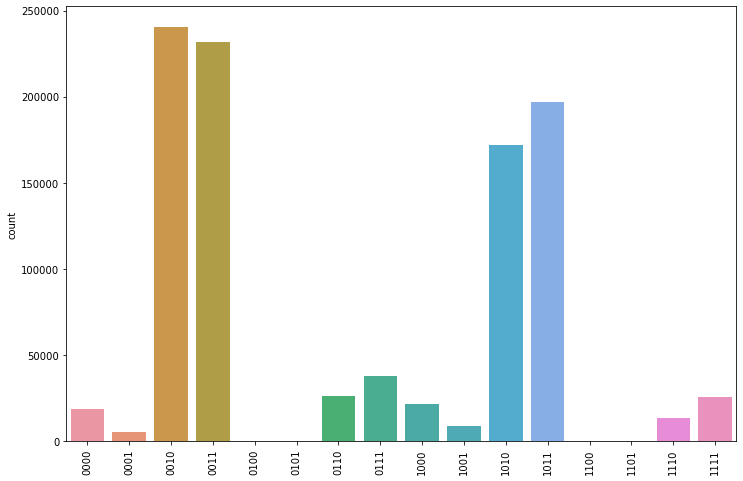

In [21]:
plt.figure(figsize=(12, 8))
sns.countplot(dist_arr, orient='v', order=order_bins)
plt.xticks(rotation=90)

Okay we can see that there are definitely far too many items in each bucket - remember that we cannot differentiate vectors that have been placed into the same bucket, so we can tell from this that our `nbits` value *must* be increased.

## Visualizing Performance

Now, let's take a look at *which* `nbits` values produce the best performance and speed.

In [22]:
from datetime import datetime

k = 50

# initialize results dataframe
results = pd.DataFrame({
    'search_time': [],
    'recall': [],
    'nbits': [],
    'nb': []
})

for epoch in range(5):
    print('.', end='')
    for nb in [50_000, 100_000, 250_000, 500_000, 750_000, 1_000_000]:
        # exhaustive search results
        index = faiss.IndexFlatL2(d)
        index.add(wb[:nb])
        start = datetime.now()
        D, I = index.search(xq0, k)
        flat_time = (datetime.now() - start).microseconds
        target_ids = I[0].tolist()
        # LSH search
        for nbits in [64, 128, 256, 512, 768, 32]:
            index = faiss.IndexLSH(d, nbits)
            index.add(wb[:nb])
            start = datetime.now()
            D, I = index.search(xq0, k)
            lsh_time = (datetime.now() - start).microseconds
            matches = [x for x in I[0].tolist() if x in target_ids]
            recall = len(matches)/k
            results = results.append(
                pd.DataFrame({
                    'search_time': [lsh_time / flat_time],
                    'recall': [recall],
                    'nbits': [nbits],
                    'nb': [nb]
                }), ignore_index=True
            )

.....

<AxesSubplot:xlabel='nb', ylabel='recall'>

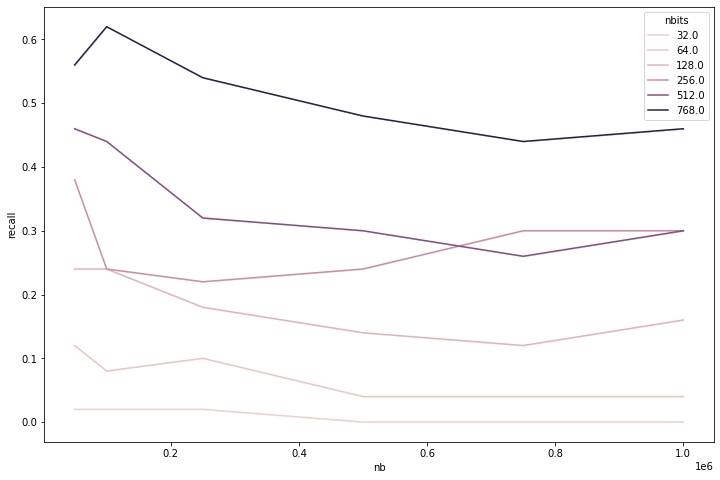

In [23]:
plt.figure(figsize=(12, 8))
sns.lineplot(data=results, x='nb', y='recall', hue='nbits')

<AxesSubplot:xlabel='nb', ylabel='search_time'>

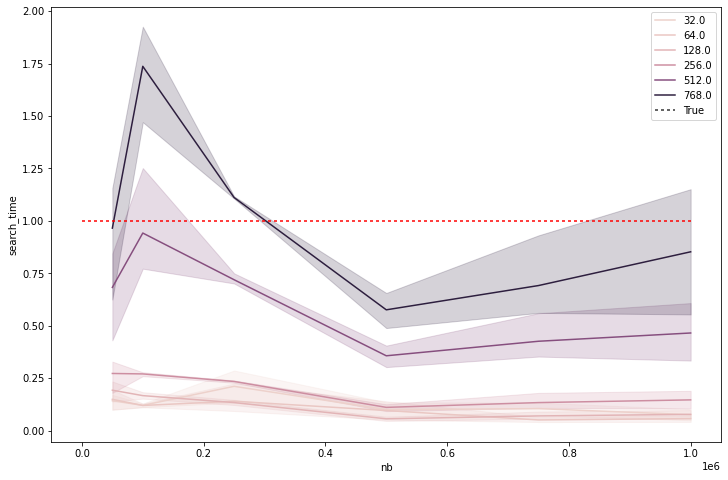

In [24]:
plt.figure(figsize=(12, 8))
sns.lineplot(data=results, x='nb', y='search_time', hue='nbits')
sns.lineplot(x=[0, 1_000_000], y=[1, 1], style=True, dashes=[(2,2)], color='r')

We certainly need to be pushing our `nbits` values high to get reasonable recall values, but we also risk making our search slower than an *exhaustive* search - so there is a bit of balancing required to find the sweet spot for each use-case.